# Figure 3 Success-Paired VNS Enhances Oligodendrogenesis

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm_notebook as tqdm

import nelpy as nel
import nelpy.plotting as npl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import chi2

from scipy import stats, integrate
import statsmodels.api as sm

# Manuscript Mode Setup (White Background / Black Text)
npl.setup(font='Arial', font_scale=2, 
          rc=({'figure.figsize': (3, 3), 
               'font.size': 12, 'axes.labelsize': 12, 
               'axes.titlesize': 12, 'legend.fontsize': 10, 
               'ytick.labelsize': 10, 'xtick.labelsize': 10,
               'xtick.direction': 'out', 'ytick.direction': 'out', 
               'xtick.major.size': 3, 'ytick.major.size': 3,
               'pdf.fonttype': 42, 'ps.fonttype': 42,
               
               # --- MANUSCRIPT MODE OVERRIDES ---
               'figure.facecolor': 'None',  # Transparent background
               'axes.facecolor': 'None',    # Transparent axes
               'savefig.facecolor': 'None', # Transparent on save
               
               'text.color': 'black',       # Black Text
               'axes.labelcolor': 'black',  # Black Axis Labels
               'xtick.color': 'black',      # Black Ticks
               'ytick.color': 'black',      # Black Ticks
               'axes.edgecolor': 'black',   # Black Spines
               
               'legend.facecolor': 'None',  # Transparent Legend
               'legend.edgecolor': 'None',  # No border on legend
               'legend.labelcolor': 'black' # Black Legend Text
               }))

import warnings
warnings.filterwarnings('ignore')
import logging

# Set the root logger's level to ERROR to suppress WARNING messages
logging.getLogger().setLevel(logging.ERROR)


%matplotlib inline 

df_fig3 = pd.read_csv("../2025-09-30Fig3.csv")
df_fig3

,ID,Marker for Cup at 34 days,Behavior,Day,phase_bin_10 days,"phase_bin_10 days 2, copy",phase_bin_7Days,phase_bin_7Days_complete,daysInPhase2,days_between_TP,...,Replacement rate w/phase for graph,Max_loss,MaxGain_normToLoss,rate between each tp,max rate after stim,max rate during stim,Asymptote,Growth Rate,Inflection Point,OL loss rate learning
0,MOBP20,NaN,learning,0.0,baseline,baseline,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MOBP20,NaN,learning,3.0,cuprizone diet,cuprizone diet,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,MOBP20,NaN,learning,7.0,cuprizone diet,cuprizone diet,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,MOBP20,NaN,learning,10.0,cuprizone diet,cuprizone diet,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,MOBP20,NaN,learning,14.0,cuprizone diet,cuprizone diet,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,MOBP111,NaN,paired_stim.,39.0,post-learning1,post-learning2,post-learning2,post-learning2,7.0,2.0,...,NaN,NaN,NaN,1.388889,NaN,NaN,NaN,NaN,NaN,NaN
335,MOBP111,NaN,paired_stim.,42.0,post-learning1,post-learning2,post-learning2,post-learning2,7.0,3.0,...,1.289683,NaN,NaN,1.388889,NaN,NaN,NaN,NaN,NaN,NaN
336,MOBP111,NaN,paired_stim.,44.0,post-learning1,post-learning3,post-learning3,post-learning3,7.0,2.0,...,NaN,NaN,NaN,1.388889,NaN,NaN,NaN,NaN,NaN,NaN
337,MOBP111,NaN,paired_stim.,46.0,post-learning1,post-learning3,post-learning3,post-learning3,7.0,2.0,...,NaN,NaN,NaN,1.041667,NaN,NaN,NaN,NaN,NaN,NaN


## Panel A (Mouse! And Reach Success Stim Paradigm)

![Figure 3 Panel A](figure3/mouseReachSuccessVNS.svg)

## Panel B (Experimental Timeline)
![Figure 3 Panel B](figure3/panelB.svg)

## Panel C
![Figure 3 Panel C](figure3/panelC.svg)

## Panel D
![Figure 3 Panel D](figure3/panelD.svg)

## Panel E
![Figure 3 Panel E](figure3/panelE.svg)

## Panel F

<div class="alert alert-block alert-info">
    <b>Methodological Note: Model Application</b><br>
    This analysis utilizes the <b>Hybrid Gompertz-GP model</b> validated in <b>Figure 1g</b>. By combining the biological constraints of an S-curve with the statistical flexibility of a Gaussian Process, this approach accurately captures the late-stage divergence (Days 20+) where the VNS trajectory continues to rise beyond the ceiling observed in the Motor Learning controls. Supplemental analysis of this was also done for the data in this figure and is provided below for reference but the actual result is at the bottom before the next panel.
</div>

Data Cleanup: Dropped 7 rows containing NaNs.
------------------------------
Sample Sizes (N) for
  - learning: 10 animals
  - paired_stim.: 6 animals
------------------------------


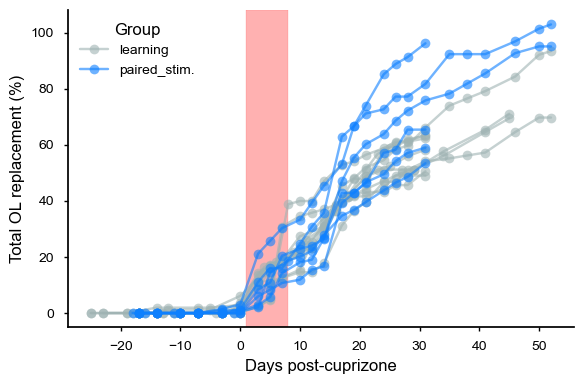

In [2]:
def plot_animal_trajectories(df, palette, id_col='ID', behavior_col='Behavior',\
                             x_col='DaysSinceCup', y_col='Total OL Replacement %'):
    """
    Plots individual animal trajectories from a dataframe.
    Automatically removes rows where 'Behavior' (or other critical data) is missing.
    """
    
    # 1. Internal Data Cleaning
    original_count = len(df)
    
    # Drop rows where critical info is missing
    plot_data = df.dropna(subset=[id_col, behavior_col, x_col, y_col]).copy()
    
    # Report cleanup results if necessary
    dropped_count = original_count - len(plot_data)
    if dropped_count > 0:
        print(f"Data Cleanup: Dropped {dropped_count} rows containing NaNs.")

    if plot_data.empty:
        print(f"Warning: Dataframe is empty after cleaning. Check your column names or data.")
        return

    # 2. Calculate and Print N per Group
    # Group by behavior and count unique IDs
    group_counts = plot_data.groupby(behavior_col)[id_col].nunique()
    
    print("-" * 30)
    print(f"Sample Sizes (N) for")
    for group, count in group_counts.items():
        # Clean up the group name for printing
        clean_group = str(group).strip()
        print(f"  - {clean_group}: {count} animals")
    print("-" * 30)
   
    # Get unique animals from the CLEAN data only
    animals = plot_data[id_col].unique()

    # 3. Setup Plot
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    
    # 4. Plot Loop
    for animal_id in animals:
        animal_subset = plot_data[plot_data[id_col] == animal_id].sort_values(x_col)
        
        if animal_subset.empty:
            continue
            
        group_val = animal_subset[behavior_col].iloc[0]
        group = str(group_val).strip()
        color = palette.get(group, 'gray')
        
        plt.plot(animal_subset[x_col], 
                 animal_subset[y_col], 
                 marker='o', 
                 linestyle='-', 
                 alpha=0.6, 
                 color=color, 
                 label=group)

    # 5. Formatting
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Group")
    
    plt.xlabel('Days post-cuprizone')
    plt.ylabel("Total OL replacement (%)")
    npl.epochplot(nel.EpochArray([[1,8]]),color='red',alpha=0.3)
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    
    plt.tight_layout()
    plt.show()
my_palette = {'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'}
plot_animal_trajectories(df_fig3, my_palette, )

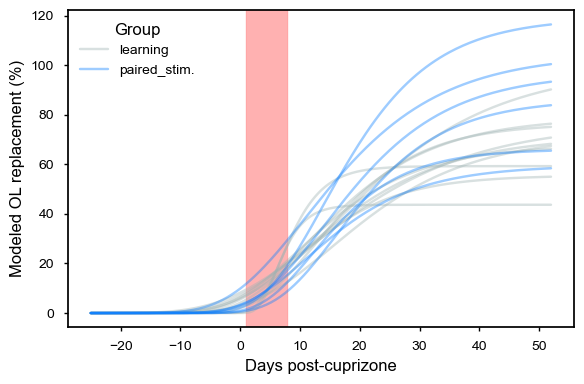

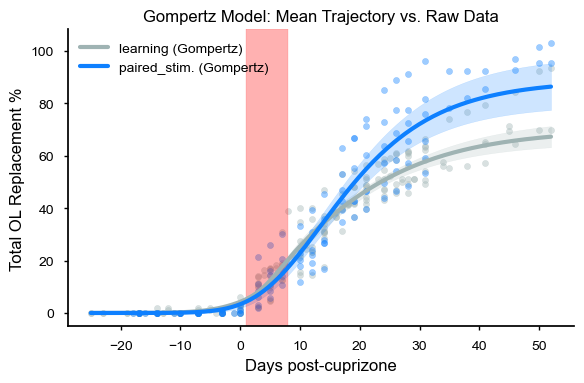

GOMPERTZ PARAMETER STATISTICS
Hypothesis: Is paired_stim. > learning?

Metric: Theoretical Max Replacement (%) [Asymptote_a]
  paired_stim.: 88.74 ± 9.33
  learning: 70.05 ± 4.76
  Difference: +18.69
----------------------------------------
  Two-Sided: p=0.0668 [n.s.]
  One-Sided: p=0.0334 [*]
................................................................................

Metric: Time of Peak Growth (Days) [Inflection_Point]
  paired_stim.: 13.08 ± 0.84
  learning: 10.98 ± 1.03
  Difference: +2.09
----------------------------------------
  Two-Sided: p=0.1814 [n.s.]
  One-Sided: p=0.0907 [n.s.]
................................................................................

Metric: Growth Rate Constant (c) [Rate_c]
  paired_stim.: 0.10 ± 0.01
  learning: 0.13 ± 0.03
  Difference: -0.03
----------------------------------------
  Two-Sided: p=0.4535 [n.s.]
  One-Sided: p=0.7733 [n.s.]
................................................................................
Fitting Group Templ

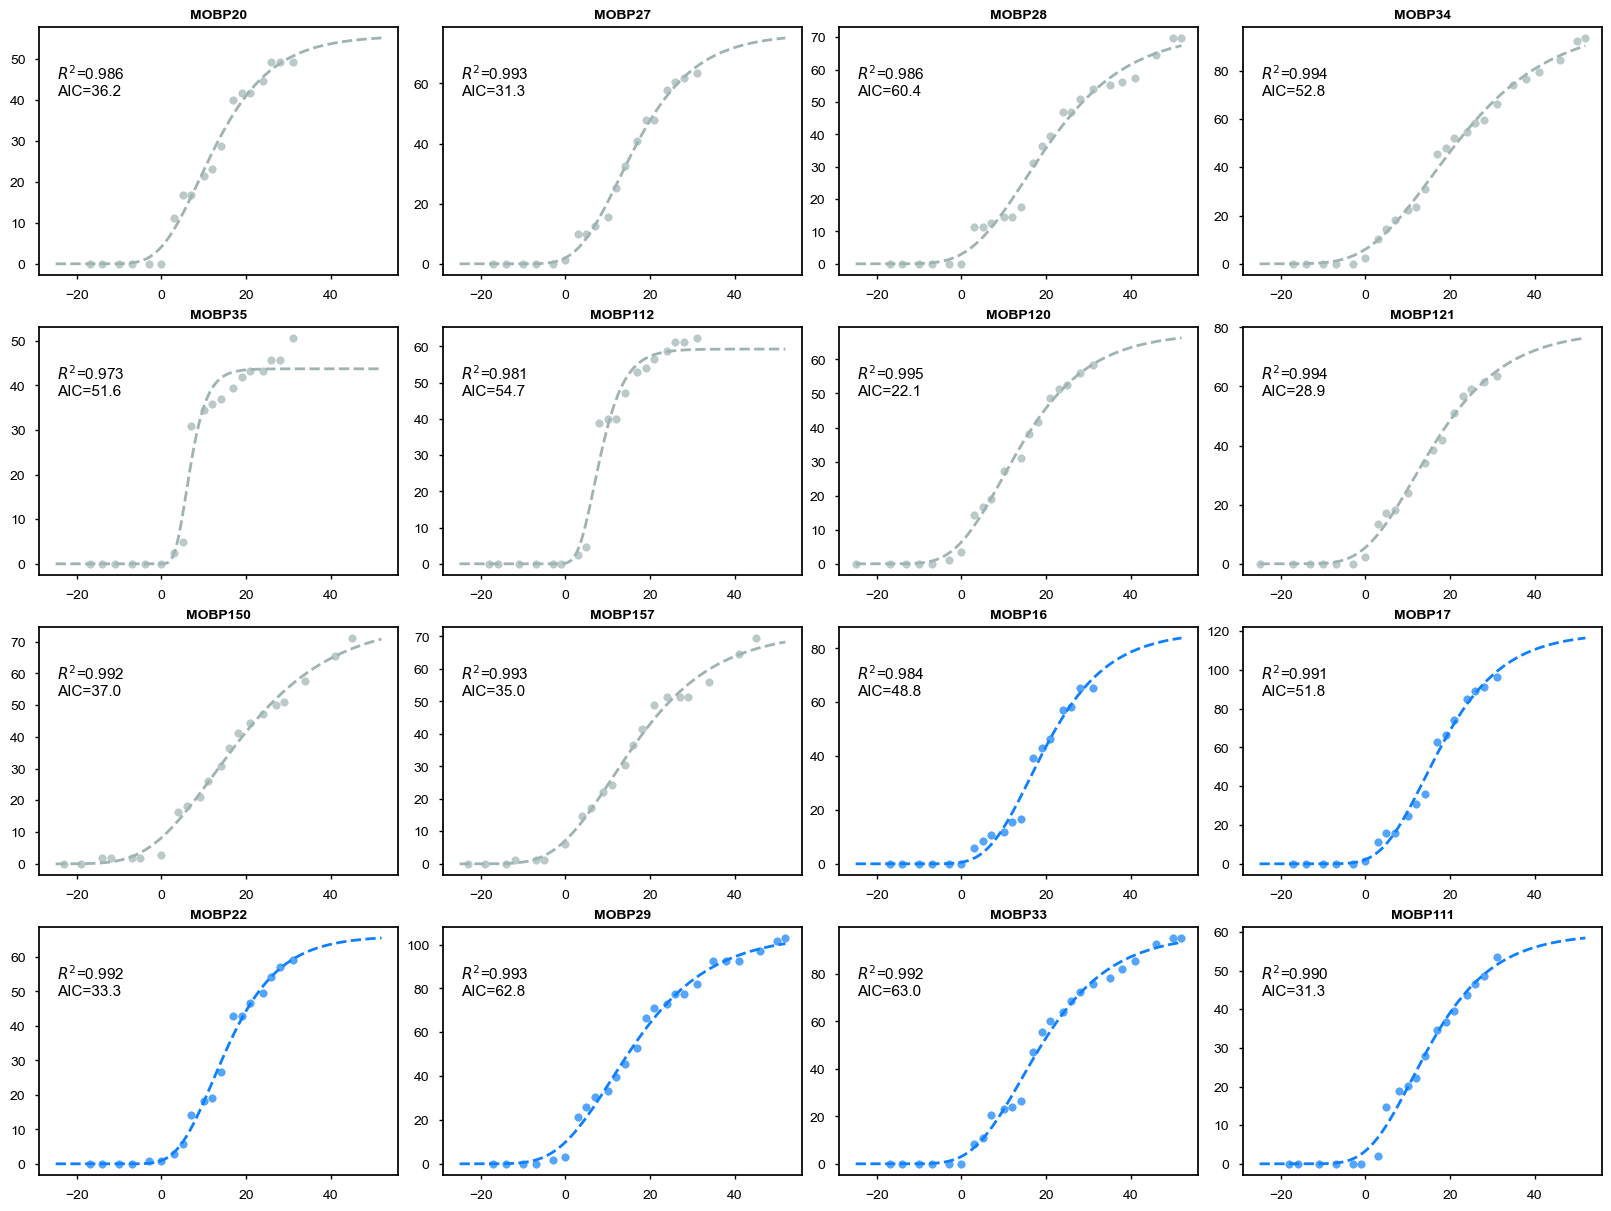

In [3]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import math

def calculate_aic(n, rss, k):
    """Calculate AIC: n * log(RSS/n) + 2k"""
    if n <= 0 or rss <= 0: return np.inf
    return n * np.log(rss / n) + 2 * k

# -----------------------------------------------------------------------------
# 1. GOMPERTZ MODEL
# -----------------------------------------------------------------------------
def gompertz(t, a, b, c):
    """
    Gompertz growth model.
    a: Asymptote (theoretical maximum)
    b: Displacement (shifts curve along x-axis)
    c: Growth rate
    """
    return a * np.exp(-b * np.exp(-c * t))

# -----------------------------------------------------------------------------
# 2. FIT AND PLOT (Returns Individual Params)
# -----------------------------------------------------------------------------
def plot_gompertz_fits(df, palette, id_col='ID', behavior_col='Behavior', plot_individual=False,\
                       x_col='DaysSinceCup', y_col='Total OL Replacement %'):
    """
    Fits a Gompertz curve to each animal individually and plots the SMOOTH modeled trajectory.
    Returns a DataFrame containing the fitted parameters for every animal.
    """
    original_count = len(df)
    plot_data = df.dropna(subset=[id_col, behavior_col, x_col, y_col]).copy()
    
    if plot_data.empty:
        print("Warning: Dataframe is empty after cleaning.")
        return pd.DataFrame() 
    
    fitted_params = []
    animals = plot_data[id_col].unique()
    
    x_min = plot_data[x_col].min()
    x_max = plot_data[x_col].max()
    x_smooth = np.linspace(x_min, x_max, 200)

    # --- SETUP PLOTTING ---
    if plot_individual:
        n_mice = len(animals)
        n_cols = 4
        n_rows = math.ceil(n_mice / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), constrained_layout=True)
        try: axes = axes.flatten()
        except: axes = [axes] # Handle single plot case
    else:
        # Standard Aggregate Plot
        plt.figure(figsize=(6, 4))
    
    ax = plt.gca()

    for i, animal_id in enumerate(animals):
        animal_subset = plot_data[plot_data[id_col] == animal_id].sort_values(x_col)
        
        if len(animal_subset) < 3:
            print(f"Skipping {animal_id}: Not enough data points to fit.")
            continue
            
        x_raw = animal_subset[x_col].values
        y_raw = animal_subset[y_col].values

        n_points = len(x_raw)
        
        group_val = animal_subset[behavior_col].iloc[0]
        group = str(group_val).strip()
        color = palette.get(group, 'gray')
        
        try:
            p0 = [max(y_raw), 10, 0.1]
            bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
            popt, pcov = curve_fit(gompertz, x_raw, y_raw, p0=p0, bounds=bounds, maxfev=10000)

            # CALC R^2
            y_pred = gompertz(x_raw, *popt)
            ss_res = np.sum((y_raw - y_pred)**2)
            ss_tot = np.sum((y_raw - np.mean(y_raw))**2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0

            # AIC (k=3 parameters for Gompertz)
            aic_score = calculate_aic(n_points, ss_res, k=3)

            if plot_individual:
                ax_curr = axes[i]
                y_smooth = gompertz(x_smooth, *popt)
                
                # Plot Raw Data
                ax_curr.scatter(x_raw, y_raw, color=color, s=30, alpha=0.7)
                # Plot Fit
                ax_curr.plot(x_smooth, y_smooth, linestyle='--', color=color, linewidth=2)
                # Add Text
                stats_text = f'$R^2$={r_squared:.3f}\nAIC={aic_score:.1f}'
                ax_curr.text(0.05, 0.85, stats_text, 
                             transform=ax_curr.transAxes, fontsize=11, 
                             verticalalignment='top')
                ax_curr.set_title(f"{animal_id}", fontsize=10, fontweight='bold')
            else:
                y_smooth = gompertz(x_smooth, *popt)
                plt.plot(x_smooth, y_smooth, linestyle='-', alpha=0.4, color=color, label=group)
            
            fitted_params.append({
                'ID': animal_id,
                'Group': group,
                'Asymptote_a': popt[0],
                'Displacement_b': popt[1],
                'Rate_c': popt[2]
            })
            
        except RuntimeError:
            print(f"Fit failed for animal {animal_id}")

    if plot_individual:
        for j in range (i+1, len(axes)): 
            axes[j].axis('off')
        plt.show()
    else:

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), title="Group")
        
        plt.xlabel('Days post-cuprizone')
        plt.ylabel("Modeled OL replacement (%)") 
        npl.epochplot(nel.EpochArray([[1,8]]), color='red', alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame(fitted_params)

# -----------------------------------------------------------------------------
# 3. STATS ON PARAMETERS (Inflection Point, Asymptote)
# -----------------------------------------------------------------------------
def analyze_gompertz_stats(df_results, target_greater_group=None):
    """
    Calculates Inflection Point and performs T-tests on parameters.
    """
    df_results['Inflection_Point'] = np.log(df_results['Displacement_b']) / df_results['Rate_c']
    groups = df_results['Group'].unique()
    
    if len(groups) != 2:
        print(f"Error: Statistics require exactly 2 groups. Found {len(groups)}.")
        return
    
    if target_greater_group and target_greater_group in groups:
        group1_name = target_greater_group
        group2_name = [g for g in groups if g != target_greater_group][0]
    else:
        group1_name, group2_name = groups[0], groups[1]
    
    g1_data = df_results[df_results['Group'] == group1_name]
    g2_data = df_results[df_results['Group'] == group2_name]
    
    print("="*80)
    print(f"GOMPERTZ PARAMETER STATISTICS")
    print(f"Hypothesis: Is {group1_name} > {group2_name}?")
    print("="*80)
    
    metrics = {
        'Asymptote_a': 'Theoretical Max Replacement (%)',
        'Inflection_Point': 'Time of Peak Growth (Days)',
        'Rate_c': 'Growth Rate Constant (c)'
    }
    
    for param, desc in metrics.items():
        vals1 = g1_data[param]
        vals2 = g2_data[param]
        
        t_2side, p_2side = stats.ttest_ind(vals1, vals2, equal_var=True, alternative='two-sided')
        t_1side, p_1side = stats.ttest_ind(vals1, vals2, equal_var=True, alternative='greater')
        
        def get_stars(p):
            if p < 0.001: return "***"
            if p < 0.01: return "**"
            if p < 0.05: return "*"
            return "n.s."

        print(f"\nMetric: {desc} [{param}]")
        print(f"  {group1_name}: {vals1.mean():.2f} ± {vals1.sem():.2f}")
        print(f"  {group2_name}: {vals2.mean():.2f} ± {vals2.sem():.2f}")
        print(f"  Difference: {vals1.mean() - vals2.mean():+.2f}")
        print("-" * 40)
        print(f"  Two-Sided: p={p_2side:.4f} [{get_stars(p_2side)}]")
        print(f"  One-Sided: p={p_1side:.4f} [{get_stars(p_1side)}]")
        print("." * 80)

# -----------------------------------------------------------------------------
# 4. EVALUATE GOODNESS OF FIT (GROUP TEMPLATE RMSE)
# -----------------------------------------------------------------------------
def run_metric_permutation_test(df, metric_col, group_col, n_perm=1000):
    groups = df[group_col].unique()
    if len(groups) != 2: return np.nan
    
    g1 = df[df[group_col] == groups[0]][metric_col].dropna().values
    g2 = df[df[group_col] == groups[1]][metric_col].dropna().values
    
    if len(g1) == 0 or len(g2) == 0: return np.nan
    
    obs_diff = np.abs(np.mean(g1) - np.mean(g2))
    pooled = np.concatenate([g1, g2])
    n1 = len(g1)
    
    null_diffs = []
    for _ in range(n_perm):
        np.random.shuffle(pooled)
        p1 = pooled[:n1]
        p2 = pooled[n1:]
        null_diffs.append(np.abs(np.mean(p1) - np.mean(p2)))
        
    return (np.sum(np.array(null_diffs) >= obs_diff) + 1) / (n_perm + 1)

def evaluate_gompertz_fit(df_raw, df_params, id_col='ID', 
                          x_col='DaysSinceCup', y_col='Total OL Replacement %'):
    """
    Calculates RMSE for 4 phases by comparing each animal's data against its GROUP TEMPLATE.
    Runs permutation tests to compare fit quality (RMSE) between groups.
    """
    
    # 1. Fit Group Templates first
    print("Fitting Group Templates (Pooled Data)...")
    templates = {}
    groups = df_params['Group'].unique()
    
    for group in groups:
        subset = df_raw.dropna(subset=[x_col, y_col])
        group_ids = df_params[df_params['Group'] == group][id_col].values
        subset = subset[subset[id_col].isin(group_ids)]
        
        x_all = subset[x_col].values
        y_all = subset[y_col].values
        
        try:
            p0 = [max(y_all), 10, 0.1]
            bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
            popt, _ = curve_fit(gompertz, x_all, y_all, p0=p0, bounds=bounds, maxfev=10000)
            templates[group] = popt
        except:
            print(f"Warning: Could not fit Group Template for {group}")
            templates[group] = [np.nan, np.nan, np.nan]

    metrics_list = []
    
    phases = [
        ('Overall', lambda x: np.full(x.shape, True, dtype=bool)),
        ('Early',   lambda x: x <= 0),
        ('Middle',  lambda x: (x > 0) & (x <= 15)),
        ('Late',    lambda x: x > 15)
    ]
    
    for index, row in df_params.iterrows():
        animal_id = row[id_col]
        group = row['Group']
        
        animal_data = df_raw[df_raw[id_col] == animal_id].dropna(subset=[x_col, y_col])
        if animal_data.empty: continue
            
        x_obs = animal_data[x_col].values
        y_obs = animal_data[y_col].values
        
        # USE GROUP TEMPLATE PARAMETERS
        if group in templates and not np.isnan(templates[group][0]):
            a, b, c = templates[group]
            y_pred = gompertz(x_obs, a, b, c)
        else:
            y_pred = np.full_like(x_obs, np.nan)
        
        row_metrics = {id_col: animal_id, 'Group': group}
        
        for phase_name, condition in phases:
            mask = condition(x_obs)
            if np.sum(mask) > 0 and not np.isnan(y_pred).all():
                rmse = np.sqrt(mean_squared_error(y_obs[mask], y_pred[mask]))
            else:
                rmse = np.nan
                
            row_metrics[f'RMSE_{phase_name}'] = rmse
            
        metrics_list.append(row_metrics)
        
    df_metrics = pd.DataFrame(metrics_list)
    
    # --- REPORTING ---
    print("="*90)
    print("GOMPERTZ GROUP TEMPLATE EVALUATION")
    print("Comparing deviation (RMSE) of individuals from the Group S-Curve")
    print("="*90)
    
    metric_cols = [c for c in df_metrics.columns if 'RMSE' in c]
    if len(groups) == 2:
        print(f"{'Metric':<18} | {groups[0]:<12} | {groups[1]:<12} | {'Diff':<8} | {'P-Value':<8}")
        print("-" * 90)
        for metric in metric_cols:
            p_val = run_metric_permutation_test(df_metrics, metric, 'Group')
            g1_mean = df_metrics[df_metrics['Group'] == groups[0]][metric].mean()
            g2_mean = df_metrics[df_metrics['Group'] == groups[1]][metric].mean()
            diff = g1_mean - g2_mean
            sig = "*" if p_val < 0.05 else "n.s."
            if p_val < 0.01: sig = "**"
            print(f"{metric:<18} | {g1_mean:>9.2f}    | {g2_mean:>9.2f}    | {diff:>+6.2f}   | {p_val:.4f} {sig}")
            
    print("-" * 90)
    print("INTERPRETATION: Significantly higher RMSE indicates the Group S-Curve fails to capture individual behavior.")
    return df_metrics

# -----------------------------------------------------------------------------
# GOMPERTZ VISUALIZATION (Mean +/- SEM)
# -----------------------------------------------------------------------------
def plot_gompertz_mean_with_sem(df_raw, df_params, palette, 
                                id_col='ID', group_col='Behavior', 
                                x_col='DaysSinceCup', y_col='Total OL Replacement %'):
    """
    Plots the MEAN Gompertz trajectory +/- SEM for each group.
    This effectively visualizes the "Average Model" vs. the "Raw Data".
    """
    
    # Setup Plot
    plt.figure(figsize=(6, 4))
    ax = plt.gca()
    
    # Define common grid for averaging
    x_min = df_raw[x_col].min()
    x_max = df_raw[x_col].max()
    x_grid = np.linspace(x_min, x_max, 200)
    
    groups = df_params['Group'].unique()
    max_y = 0
    
    for group in groups:
        color = palette.get(str(group).strip(), 'gray')
        
        # Get parameters for all animals in this group
        group_params = df_params[df_params['Group'] == group]
        
        # 1. Generate curves for EVERY animal on the common grid
        individual_curves = []
        
        for _, row in group_params.iterrows():
            a, b, c = row['Asymptote_a'], row['Displacement_b'], row['Rate_c']
            
            # Predict on grid
            y_pred = gompertz(x_grid, a, b, c)
            individual_curves.append(y_pred)
            
        if not individual_curves: continue
        
        # 2. Calculate Mean and SEM across the population of curves
        curve_array = np.array(individual_curves)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean_curve = np.nanmean(curve_array, axis=0)
            sem_curve = stats.sem(curve_array, axis=0)
            
        # 3. Plot the Model (Line + Ribbon)
        plt.plot(x_grid, mean_curve, color=color, linewidth=3, label=f"{group} (Gompertz)")
        plt.fill_between(x_grid, 
                         mean_curve - sem_curve, 
                         mean_curve + sem_curve, 
                         color=color, alpha=0.2)
        
        # 4. Plot the Raw Data
        # We need to map the group name back to the raw dataframe's group column
        # Assuming direct string match or stripping
        subset_raw = df_raw.dropna(subset=[group_col])
        subset_raw = subset_raw[subset_raw[group_col].astype(str).str.strip() == str(group).strip()]
        
        plt.scatter(subset_raw[x_col], subset_raw[y_col], color=color, alpha=0.4, s=20)
        
        if not subset_raw.empty:
            current_max = subset_raw[y_col].max()
            if current_max > max_y: max_y = current_max

    # Formatting
    npl.epochplot(nel.EpochArray([[1,8]]), color='red', alpha=0.3)
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    
    plt.title("Gompertz Model: Mean Trajectory vs. Raw Data")
    plt.xlabel("Days post-cuprizone")
    plt.ylabel(y_col)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
df_results_fig3 = plot_gompertz_fits(df_fig3, palette={'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'})
plot_gompertz_mean_with_sem(df_fig3, df_results_fig3, 
                            palette={'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'})
analyze_gompertz_stats(df_results_fig3, target_greater_group="paired_stim.")
evaluate_gompertz_fit(df_fig3, df_results_fig3)
df_results_fig3 = plot_gompertz_fits(df_fig3, palette={'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'},plot_individual=True)

NON-PARAMETRIC ROBUSTNESS CHECK (Mann-Whitney U)
Hypothesis Direction: Is paired_stim. > Control?

Metric: Max_Value (per animal)
  paired_stim. (Target): 78.75 ± 8.89 (n=6)
  learning (Control): 65.14 ± 3.96 (n=10)
----------------------------------------
  Two-Sided Mann-Whitney: U=41.0, p=0.2635 [n.s.]
  One-Sided Mann-Whitney: U=41.0, p=0.1317 [n.s.] (Testing paired_stim. > learning)
................................................................................

Metric: AUC (per animal)
  paired_stim. (Target): 31.24 ± 5.68 (n=6)
  learning (Control): 25.95 ± 2.08 (n=10)
----------------------------------------
  Two-Sided Mann-Whitney: U=33.0, p=0.7925 [n.s.]
  One-Sided Mann-Whitney: U=33.0, p=0.3962 [n.s.] (Testing paired_stim. > learning)
................................................................................

LOESS SMOOTHING DETAILS (Target Window: ~21 Days)
Group 'learning': Duration=77.0d -> using frac=0.27
Group 'paired_stim.': Duration=70.0d -> using frac=0.30


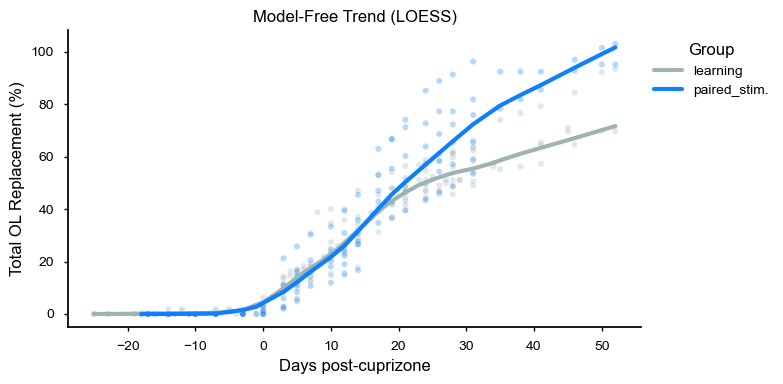

In [4]:
def analyze_non_parametric(df, palette, target_greater_group=None,
                           smoothing_window_days=7,\
                           id_col='ID', group_col='Behavior',\
                           x_col='DaysSinceCup', y_col='Total OL Replacement %'):
    """
    Performs model-free validation:
    1. Calculates Max Observed Value & AUC per animal.
    2. Runs Mann-Whitney U Tests (Two-Sided AND One-Sided).
    3. Plots CUSTOM LOESS curves (Physics-Constrained + Tunable Window).
    
    Args:
        target_greater_group (str): The name of the group you hypothesize is LARGER.
                                    (e.g., 'VNS').
        smoothing_window_days (int): The size of the smoothing window in X-axis units (Days).
                                     Larger = smoother line (less detail).
                                     Smaller = wigglier line (more noise).
    """
    
    # 1. CLEAN DATA
    df_clean = df.dropna(subset=[id_col, group_col, x_col, y_col]).copy()
    metrics_list = []
    
    # 2. CALCULATE SUMMARY METRICS (Per Animal)
    animals = df_clean[id_col].unique()
    
    for animal in animals:
        subset = df_clean[df_clean[id_col] == animal].sort_values(x_col)
        
        if len(subset) < 2: 
            continue # Need points to make a curve
            
        x = subset[x_col].values
        y = subset[y_col].values
        
        # Metric A: Max Observed Value (The empirical ceiling)
        max_val = np.max(y)
        
        # Metric B: AUC (Area Under Curve) - Normalized by duration
        # This represents "Total Exposure" to replacement over the experiment
        duration = x[-1] - x[0]
        if duration > 0:
            # Trapz calculates area using trapezoids connecting the dots
            auc = integrate.trapezoid(y, x) / duration
        else:
            auc = 0
            
        metrics_list.append({
            'ID': animal,
            'Group': str(subset[group_col].iloc[0]).strip(), # strip whitespace
            'Max_Value': max_val,
            'AUC': auc
        })
        
    df_metrics = pd.DataFrame(metrics_list)
    
    # 3. STATISTICAL REPORT
    print("="*80)
    print("NON-PARAMETRIC ROBUSTNESS CHECK (Mann-Whitney U)")
    if target_greater_group:
        print(f"Hypothesis Direction: Is {target_greater_group} > Control?")
    else:
        print("Hypothesis: Two-Sided (Any Difference)")
    print("="*80)
    
    groups = df_metrics['Group'].unique()
    if len(groups) != 2:
        print(f"Error: Need exactly 2 groups. Found: {groups}")
        return
    
    # Identify Target vs Control
    if target_greater_group:
        if target_greater_group not in groups:
             print(f"Error: target_greater_group '{target_greater_group}' not found. Available: {groups}")
             return
        g1_name = target_greater_group
        g2_name = [g for g in groups if g != target_greater_group][0]
    else:
        g1_name, g2_name = groups[0], groups[1]

    g1 = df_metrics[df_metrics['Group'] == g1_name]
    g2 = df_metrics[df_metrics['Group'] == g2_name]
    
    # Helper for stars
    def get_stars(p):
        if p < 0.001: return "***"
        if p < 0.01:  return "**"
        if p < 0.05:  return "*"
        return "n.s."

    # Test both metrics
    for metric in ['Max_Value', 'AUC']:
        # 1. Two-Sided Test
        u_2, p_2 = stats.mannwhitneyu(g1[metric], g2[metric], alternative='two-sided')
        
        # 2. One-Sided Test (Greater)
        u_1, p_1 = stats.mannwhitneyu(g1[metric], g2[metric], alternative='greater')
        
        mean1, se1 = g1[metric].mean(), g1[metric].sem()
        mean2, se2 = g2[metric].mean(), g2[metric].sem()
        
        stars_2 = get_stars(p_2)
        stars_1 = get_stars(p_1)
        
        print(f"\nMetric: {metric} (per animal)")
        print(f"  {g1_name} (Target): {mean1:.2f} ± {se1:.2f} (n={len(g1)})")
        print(f"  {g2_name} (Control): {mean2:.2f} ± {se2:.2f} (n={len(g2)})")
        print("-" * 40)
        print(f"  Two-Sided Mann-Whitney: U={u_2}, p={p_2:.4f} [{stars_2}]")
        print(f"  One-Sided Mann-Whitney: U={u_1}, p={p_1:.4f} [{stars_1}] (Testing {g1_name} > {g2_name})")
        print("." * 80)

    # 4. VISUALIZATION: LOESS PLOT
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    
    # A. Plot Raw Data (Faint background dots)
    sns.scatterplot(data=df_clean, x=x_col, y=y_col, hue=group_col, palette=palette, 
                    alpha=0.3, s=20, legend=False)
    # B. Plot Smooth Lines (Manual Calculation)
    print("\n" + "="*60)
    print(f"LOESS SMOOTHING DETAILS (Target Window: ~{smoothing_window_days} Days)")
    print("="*60)

    for group in groups:
        subset = df_clean[df_clean[group_col] == group].sort_values(x_col)
        if subset.empty: continue
            
        x_vals = subset[x_col].values
        y_vals = subset[y_col].values
        color = palette.get(str(group).strip(), 'gray')
        
        # --- DYNAMIC FRACTION CALCULATION ---
        # Convert "Days" into the "Fraction" that statsmodels requires
        duration = x_vals.max() - x_vals.min()
        if duration > 0:
            frac = smoothing_window_days / duration
        else:
            frac = 0.3
        
        # Keep frac within safe bounds (0.05 to 1.0)
        frac = max(0.05, min(1.0, frac))
        
        # --- MANUAL LOESS CALCULATION ---
        # Calculate the smooth curve
        lowess = sm.nonparametric.lowess(y_vals, x_vals, frac=frac)
        lowess_x = lowess[:, 0]
        lowess_y = lowess[:, 1]
        
        # --- THE FIX: CLAMP NEGATIVE VALUES ---
        # Force the curve to respect biology (cannot have negative cells)
        lowess_y_clamped = np.clip(lowess_y, 0, None)
        
        # Plot the result
        plt.plot(lowess_x, lowess_y_clamped, color=color, linewidth=3, label=group)
        print(f"Group '{group}': Duration={duration:.1f}d -> using frac={frac:.2f}")

    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    
    plt.title("Model-Free Trend (LOESS)")
    plt.xlabel("Days post-cuprizone")
    plt.ylabel("Total OL Replacement (%)")
    plt.legend(title='Group', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
analyze_non_parametric(df_fig3, palette={'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'},target_greater_group ='paired_stim.',smoothing_window_days=21)

STEP 1: Generating Individual GP Curves...
STEP 2: Running Rolling Hierarchical Permutation...
Running Rolling Stats (Window=5d, Step=2d, N=1000)...

Rolling Stats Complete.


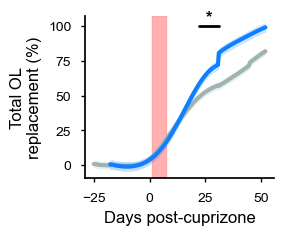

In [5]:
# -----------------------------------------------------------------------------
# 1. HELPER: GENERATE HIERARCHICAL CURVES (PRE-FIT)
# -----------------------------------------------------------------------------
def get_individual_gp_curves(df, id_col, group_col, x_col, y_col, grid):
    """
    Fits a GP to each animal individually and returns the predicted curves.
    """
    groups = df[group_col].unique()
    animals = df[id_col].unique()
    
    curves = {}
    labels = {}
    
    # Kernel: RBF for shape + WhiteKernel for individual animal noise
    base_kernel = C(1.0) * RBF(length_scale=10.0, length_scale_bounds=(2, 60)) + \
                  WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 5))

    for animal in animals:
        subset = df[df[id_col] == animal].dropna(subset=[x_col, y_col]).sort_values(x_col)
        if len(subset) < 2: continue
        
        # Get Group
        group = subset[group_col].iloc[0]
        labels[animal] = str(group).strip()
        
        # Fit GP
        X = subset[x_col].values.reshape(-1, 1)
        y = subset[y_col].values
        gp = GaussianProcessRegressor(kernel=base_kernel, n_restarts_optimizer=5, normalize_y=True)
        gp.fit(X, y)
        
        # Predict on common grid
        y_pred = gp.predict(grid, return_std=False)
        
        # STRICT MASKING (No Extrapolation)
        min_d, max_d = subset[x_col].min(), subset[x_col].max()
        y_pred[grid.flatten() < min_d] = np.nan
        y_pred[grid.flatten() > max_d] = np.nan
        
        curves[animal] = y_pred
        
    return curves, labels

# -----------------------------------------------------------------------------
# 2. STATISTICAL ENGINE (HIERARCHICAL LIKELIHOOD)
# -----------------------------------------------------------------------------
def calculate_hierarchical_D(curve_matrix, group_assignments):
    """
    Calculates D = 2 * (LL_Separate - LL_Shared) based on curve distributions.
    """
    # 1. SHARED MODEL (Grand Mean & Variance)
    mu_all = np.nanmean(curve_matrix, axis=0)
    var_all = np.nanvar(curve_matrix, axis=0) + 1e-6 
    
    # Log-Likelihood (Shared)
    resid_sq_all = (curve_matrix - mu_all) ** 2
    ll_terms_all = -0.5 * np.log(var_all) - (resid_sq_all / (2 * var_all))
    LL_shared = np.nansum(ll_terms_all)

    # 2. SEPARATE MODELS
    LL_separate = 0
    unique_groups = np.unique(group_assignments)
    
    for g in unique_groups:
        indices = [i for i, x in enumerate(group_assignments) if x == g]
        if len(indices) == 0: continue
        
        sub_matrix = curve_matrix[indices]
        
        # Group Parameters
        mu_g = np.nanmean(sub_matrix, axis=0)
        var_g = np.nanvar(sub_matrix, axis=0) + 1e-6
        
        # Group Likelihood
        resid_sq_g = (sub_matrix - mu_g) ** 2
        ll_terms_g = -0.5 * np.log(var_g) - (resid_sq_g / (2 * var_g))
        LL_separate += np.nansum(ll_terms_g)
        
    # 3. STATISTIC
    return 2 * (LL_separate - LL_shared)

def run_rolling_hierarchical_permutation(curve_dict, label_dict, grid, 
                                         start_day, end_day, 
                                         window_size, step_size, 
                                         n_permutations=1000, random_state=42):
    """
    Slides a window across the curves and runs stats.
    """
    ids = list(curve_dict.keys())
    full_curves = np.array([curve_dict[i] for i in ids]) 
    true_labels = np.array([label_dict[i] for i in ids])
    
    rng = np.random.default_rng(random_state)
    results = []
    curr_start = start_day
    
    print(f"Running Rolling Stats (Window={window_size}d, Step={step_size}d, N={n_permutations})...")
    
    while curr_start + window_size <= end_day:
        curr_end = curr_start + window_size
        
        # Mask curves for this window
        window_curves = full_curves.copy()
        mask_indices = (grid.flatten() < curr_start) | (grid.flatten() > curr_end)
        window_curves[:, mask_indices] = np.nan
        
        # Calculate Observed D
        try:
            D_obs = calculate_hierarchical_D(window_curves, true_labels)
        except:
            curr_start += step_size
            continue

        # Permutation Loop
        null_scores = []
        for _ in range(n_permutations):
            shuffled_labels = rng.permutation(true_labels)
            try:
                D_null = calculate_hierarchical_D(window_curves, shuffled_labels)
                null_scores.append(D_null)
            except:
                continue
        
        if len(null_scores) > 0:
            null_scores = np.array(null_scores)
            p_val = (np.sum(null_scores >= D_obs) + 1) / (len(null_scores) + 1)
            results.append((curr_start, curr_end, p_val))
            
        curr_start += step_size
        
    print("\nRolling Stats Complete.")
    return results

def merge_significant_windows(windows):
    """
    Merges overlapping or continuous windows into single blocks.
    Tracks the MINIMUM p-value (peak significance) for that block.
    """
    if not windows: return []
    # Sort by start time
    windows.sort(key=lambda x: x[0])
    
    merged = []
    if not windows: return merged
    
    curr_start, curr_end, curr_min_p = windows[0]
    
    for i in range(1, len(windows)):
        next_start, next_end, next_p = windows[i]
        
        # Check overlap (next start <= curr end)
        # We allow a small epsilon for float precision
        if next_start <= curr_end + 0.1: 
            curr_end = max(curr_end, next_end)
            curr_min_p = min(curr_min_p, next_p) # Keep strongest significance
        else:
            merged.append((curr_start, curr_end, curr_min_p))
            curr_start, curr_end, curr_min_p = next_start, next_end, next_p
            
    merged.append((curr_start, curr_end, curr_min_p))
    return merged

# -----------------------------------------------------------------------------
# 3. MAIN WRAPPER
# -----------------------------------------------------------------------------
import re
def analyze_gaussian_process(df, palette, 
                             stats_window_size=5, stats_step_size=2,
                             n_permutations=1000, random_state=42, 
                             id_col='ID', group_col='Behavior', 
                             x_col='DaysSinceCup', y_col='Total OL Replacement %',
                             constant_sem=True): 
    
    df_clean = df.dropna(subset=[id_col, group_col, x_col, y_col]).copy()
    groups = df_clean[group_col].unique()
    
    # Grid Setup
    global_min = df_clean[x_col].min()
    global_max = df_clean[x_col].max()
    x_grid = np.linspace(global_min, global_max, 200).reshape(-1, 1)
    
    # --- 1. FIT INDIVIDUALS ---
    print("="*60)
    print("STEP 1: Generating Individual GP Curves...")
    curves_dict, labels_dict = get_individual_gp_curves(df_clean, id_col, group_col, x_col, y_col, x_grid)
    
    # --- 2. ROLLING STATISTICS ---
    merged_sig_windows = []
    
    if len(groups) == 2:
        print("STEP 2: Running Rolling Hierarchical Permutation...")
        stats_start = max(0, global_min) 
        stats_end = global_max
        
        raw_windows = run_rolling_hierarchical_permutation(curves_dict, labels_dict, x_grid,
                                                           start_day=stats_start, 
                                                           end_day=stats_end,
                                                           window_size=stats_window_size,
                                                           step_size=stats_step_size,
                                                           n_permutations=n_permutations,
                                                           random_state=random_state)
        # Filter for raw significance first
        sig_windows = [r for r in raw_windows if r[2] < 0.05]
        
        # Merge overlapping windows
        merged_sig_windows = merge_significant_windows(sig_windows)
        
    print("="*60)

    # --- 3. PLOTTING ---
    plt.figure(figsize=(3, 2.5))
    ax = plt.gca()
    max_y = 0
    
    for group in groups:
        color = palette.get(str(group).strip(), 'gray')
        group_ids = [k for k, v in labels_dict.items() if v == group]
        if not group_ids: continue
        
        group_curve_matrix = np.array([curves_dict[i] for i in group_ids])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_curve = np.nanmean(group_curve_matrix, axis=0)
            sem_variable = stats.sem(group_curve_matrix, axis=0, nan_policy='omit')
            
            if constant_sem:
                avg_sem = np.nanmean(sem_variable)
                sem_plot = np.full_like(mean_curve, avg_sem)
            else:
                sem_plot = sem_variable
                
        plt.plot(x_grid, mean_curve, color=color, linewidth=3, label=group)
        plt.fill_between(x_grid.ravel(), 
                         mean_curve - sem_plot, mean_curve + sem_plot, 
                         color=color, alpha=0.2)
        
        sub = df_clean[df_clean[group_col] == group]
        # plt.scatter(sub[x_col], sub[y_col], color=color, alpha=0.4, s=20)
        
        # Track Max Y
        curr_max = np.nanmax(mean_curve + sem_plot)
        if curr_max > max_y: max_y = curr_max
        if sub[y_col].max() > max_y: max_y = sub[y_col].max()

    # --- 4. PLOT MERGED BARS ---
    if merged_sig_windows:
        base_y = 100#max_y * 1.05
        
        for w_start, w_end, min_p in merged_sig_windows:
            if min_p < 0.001: star = "***"
            elif min_p < 0.01: star = "**"
            elif min_p < 0.05: star = "*"
            else: continue
            
            center = (w_start + w_end) / 2
            
            # Draw line
            plt.plot([w_start, w_end], [base_y, base_y], color='black', linewidth=2)
            # Add star
            plt.text(center, base_y * 1.01, star, ha='center', va='bottom', fontsize=12, fontweight='bold')

    npl.epochplot(nel.EpochArray([[1,8]]), color='red', alpha=0.3, height=85)
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    # plt.title("Hierarchical GP with Rolling Significance")
    plt.xlabel("Days post-cuprizone")
    plt.ylabel("Total OL\nreplacement (%)")
    # plt.legend(loc='upper left')
    plt.tight_layout()
    group_names = sorted(palette.keys()) # Sort to ensure consistent filename order
    camel_case_groups = "".join([re.sub(r'[^a-zA-Z0-9]', '', s).title() for s in group_names])
    
    filename = "totalOLReplacement" + camel_case_groups + ".pdf"
    
    # plt.savefig(filename,bbox_inches='tight',format='pdf')
    plt.show()
analyze_gaussian_process(df_fig3, palette={'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'},\
                         stats_window_size=5, stats_step_size=2,)

Fitting Hybrid Models for 16 mice...

HYBRID PARAMETER STATISTICS (Permutation of MEDIANS, N=10000)

Metric: Asymptote
learning       : Median= 71.56 (IQR=15.06)
paired_stim.   : Median= 91.55 (IQR=31.41)
P-Value        : 0.04300 *

Metric: Inflection_Day
learning       : Median= 11.27 (IQR=3.52)
paired_stim.   : Median= 13.11 (IQR=2.78)
P-Value        : 0.27317 

SLIDING WINDOW STATISTICS (Trajectory)
Significant Windows found: ['20.0-49.0']


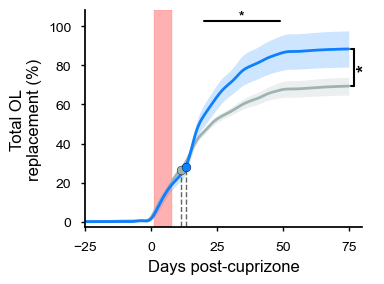

In [6]:
# -----------------------------------------------------------------------------
# 1. THE HYBRID MODEL CLASS
# -----------------------------------------------------------------------------
class GompertzGP_Uncapped:
    def __init__(self):
        self.gompertz_params = None
        self.gp = GaussianProcessRegressor(
            kernel=RBF(length_scale=10.0, length_scale_bounds=(2, 120)) + 
                   WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 2)),
            n_restarts_optimizer=10,
            normalize_y=True
        )
        
    def _gompertz_func(self, t, a, b, c):
        exponent = -c * t
        exponent = np.clip(exponent, -700, 700)
        return a * np.exp(-b * np.exp(exponent))

    def fit(self, X, y):
        max_y = np.max(y)
        try:
            p0 = [max_y * 1.5, 5, 0.05] 
            bounds = ([0, 0, 0], [500, 5000, 5]) 
            self.gompertz_params, _ = curve_fit(self._gompertz_func, X.ravel(), y, 
                                                p0=p0, bounds=bounds, maxfev=20000)
        except:
            self.gompertz_params = [max_y, 0, 0]

        ideal_trend = self._gompertz_func(X.ravel(), *self.gompertz_params)
        residuals = y - ideal_trend
        self.gp.fit(X, residuals)
        return self

    def predict(self, X):
        trend = self._gompertz_func(X.ravel(), *self.gompertz_params)
        correction = self.gp.predict(X, return_std=False)
        return trend + correction

    def get_biological_parameters(self):
        a, b, c = self.gompertz_params
        asymptote = a
        if c > 0 and b > 0:
            inflection_time = np.log(b) / c
        else:
            inflection_time = np.nan
        return asymptote, inflection_time

# -----------------------------------------------------------------------------
# 2. DATA EXTRACTION
# -----------------------------------------------------------------------------
def get_hybrid_data(df, id_col, group_col, x_col, y_col, grid):
    curves = {}
    labels = {}
    parameters = []
    
    animals = df[id_col].unique()
    print(f"Fitting Hybrid Models for {len(animals)} mice...")
    
    for animal in animals:
        subset = df[df[id_col] == animal].dropna(subset=[x_col, y_col]).sort_values(x_col)
        if len(subset) < 3: continue 
        
        group = str(subset[group_col].iloc[0]).strip()
        X = subset[x_col].values.reshape(-1, 1)
        y = subset[y_col].values
        
        model = GompertzGP_Uncapped()
        model.fit(X, y)
        
        y_pred = model.predict(grid)
        curves[animal] = y_pred
        labels[animal] = group
        
        asymp, inflect = model.get_biological_parameters()
        parameters.append({
            'ID': animal, 'Group': group,
            'Asymptote': asymp, 'Inflection_Day': inflect
        })
        
    return curves, labels, pd.DataFrame(parameters)

# -----------------------------------------------------------------------------
# 3. STATS ENGINES
# -----------------------------------------------------------------------------
def calculate_hierarchical_D(curve_matrix, group_assignments):
    mu_all = np.nanmean(curve_matrix, axis=0)
    var_all = np.nanvar(curve_matrix, axis=0) + 1e-6 
    resid_sq_all = (curve_matrix - mu_all) ** 2
    LL_shared = np.nansum(-0.5 * np.log(var_all) - (resid_sq_all / (2 * var_all)))

    LL_separate = 0
    unique_groups = np.unique(group_assignments)
    for g in unique_groups:
        indices = [i for i, x in enumerate(group_assignments) if x == g]
        if len(indices) == 0: continue
        sub_matrix = curve_matrix[indices]
        mu_g = np.nanmean(sub_matrix, axis=0)
        var_g = np.nanvar(sub_matrix, axis=0) + 1e-6
        resid_sq_g = (sub_matrix - mu_g) ** 2
        LL_separate += np.nansum(-0.5 * np.log(var_g) - (resid_sq_g / (2 * var_g)))
        
    return 2 * (LL_separate - LL_shared)

def run_rolling_stats(curves_dict, labels_dict, grid, start_day, end_day, window, step, n_perm):
    ids = list(curves_dict.keys())
    full_curves = np.array([curves_dict[i] for i in ids]) 
    true_labels = np.array([labels_dict[i] for i in ids])
    rng = np.random.default_rng(42)
    results = []
    
    curr = start_day
    while curr + window <= end_day:
        w_curves = full_curves.copy()
        mask = (grid.flatten() < curr) | (grid.flatten() > curr + window)
        w_curves[:, mask] = np.nan
        
        try:
            D_obs = calculate_hierarchical_D(w_curves, true_labels)
            nulls = [calculate_hierarchical_D(w_curves, rng.permutation(true_labels)) for _ in range(n_perm)]
            p_val = (np.sum(np.array(nulls) >= D_obs) + 1) / (n_perm + 1)
            results.append((curr, curr+window, p_val))
        except: pass
        curr += step
    return results

def merge_significant_windows(windows):
    if not windows: return []
    windows.sort(key=lambda x: x[0])
    merged = []
    curr_s, curr_e, curr_p = windows[0]
    for next_s, next_e, next_p in windows[1:]:
        if next_s <= curr_e + 0.1:
            curr_e = max(curr_e, next_e)
            curr_p = min(curr_p, next_p)
        else:
            merged.append((curr_s, curr_e, curr_p))
            curr_s, curr_e, curr_p = next_s, next_e, next_p
    merged.append((curr_s, curr_e, curr_p))
    return merged

def permutation_test_params_median(df_params, metric_col, group_col='Group', n_perm=10000):
    groups = df_params[group_col].unique()
    if len(groups) != 2: return "N/A"
    g1, g2 = groups[0], groups[1]
    vals1 = df_params[df_params[group_col] == g1][metric_col].values
    vals2 = df_params[df_params[group_col] == g2][metric_col].values
    vals1, vals2 = vals1[~np.isnan(vals1)], vals2[~np.isnan(vals2)]
    
    if len(vals1) == 0 or len(vals2) == 0: return "Insufficient Data"
    
    obs_diff = np.median(vals1) - np.median(vals2)
    combined = np.concatenate([vals1, vals2])
    n1 = len(vals1)
    rng = np.random.default_rng(42)
    null_diffs = []
    for _ in range(n_perm):
        shuffled = rng.permutation(combined)
        null_diffs.append(np.median(shuffled[:n1]) - np.median(shuffled[n1:]))
        
    p_value = (np.sum(np.abs(null_diffs) >= np.abs(obs_diff)) + 1) / (n_perm + 1)
    
    return {
        'Comparison': f"{g1} vs {g2}", 'Metric': metric_col,
        f'{g1}_Median': np.median(vals1), f'{g1}_IQR': stats.iqr(vals1),
        f'{g2}_Median': np.median(vals2), f'{g2}_IQR': stats.iqr(vals2),
        'P_Value': p_value
    }

# -----------------------------------------------------------------------------
# 4. MAIN FUNCTION
# -----------------------------------------------------------------------------
def analyze_hybrid_process(df, palette, 
                           stats_window_size=5, stats_step_size=1,
                           n_permutations=1000, 
                           id_col='ID', group_col='Behavior', 
                           x_col='DaysSinceCup', y_col='Total OL Replacement %',
                           filename=None):
    
    df_clean = df.dropna(subset=[id_col, group_col, x_col, y_col]).copy()
    
    data_min = df_clean[x_col].min()
    projection_max = 75  # <--- CUT X-AXIS AT 75 DAYS
    x_grid = np.linspace(data_min, projection_max, 300).reshape(-1, 1)
    
    curves, labels, df_params = get_hybrid_data(df_clean, id_col, group_col, x_col, y_col, x_grid)
    
    print("\n" + "="*80 + "\nHYBRID PARAMETER STATISTICS (Permutation of MEDIANS, N=10000)\n" + "="*80)
    asymp_p_val = None
    inflect_medians = {}
    
    for metric in ['Asymptote', 'Inflection_Day']:
        res = permutation_test_params_median(df_params, metric, group_col='Group')
        if isinstance(res, dict):
            g1, g2 = res['Comparison'].split(' vs ')
            print(f"\nMetric: {metric}")
            print(f"{g1:15}: Median={res[f'{g1}_Median']:6.2f} (IQR={res[f'{g1}_IQR']:4.2f})")
            print(f"{g2:15}: Median={res[f'{g2}_Median']:6.2f} (IQR={res[f'{g2}_IQR']:4.2f})")
            print(f"P-Value        : {res['P_Value']:.5f} {'*' if res['P_Value']<0.05 else ''}")
            
            if metric == 'Asymptote': asymp_p_val = res['P_Value']
            if metric == 'Inflection_Day':
                inflect_medians[g1] = res[f'{g1}_Median']
                inflect_medians[g2] = res[f'{g2}_Median']

    print("\n" + "="*80 + "\nSLIDING WINDOW STATISTICS (Trajectory)\n" + "="*80)
    raw_wins = run_rolling_stats(curves, labels, x_grid, data_min, projection_max, 
                                 stats_window_size, stats_step_size, n_permutations)
    sig_wins = merge_significant_windows([w for w in raw_wins if w[2] < 0.05])
    
    if sig_wins:
        print(f"Significant Windows found: {[f'{s:.1f}-{e:.1f}' for s,e,p in sig_wins]}")
    else:
        print("No significant windows found.")

    # --- PLOTTING ---
    plt.figure(figsize=(4, 3))
    ax = plt.gca()
    groups = df_clean[group_col].unique()
    max_y_plotted = 0
    group_means = {}
    
    for group in groups:
        color = palette.get(str(group).strip(), 'gray')
        g_ids = [k for k, v in labels.items() if v == str(group).strip()]
        if not g_ids: continue
        g_curves = np.array([curves[i] for i in g_ids])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean_curve = np.nanmean(g_curves, axis=0)
            sem_curve = stats.sem(g_curves, axis=0, nan_policy='omit')
            
        plt.plot(x_grid, mean_curve, color=color, linewidth=2, label=group)
        plt.fill_between(x_grid.flatten(), 
                         mean_curve - sem_curve, mean_curve + sem_curve, 
                         color=color, alpha=0.2, linewidth=0)
        
        if np.nanmax(mean_curve + sem_curve) > max_y_plotted: 
            max_y_plotted = np.nanmax(mean_curve + sem_curve)
        group_means[str(group).strip()] = (x_grid.flatten(), mean_curve)

    # Sliding Window Significance Bars
    if sig_wins:
        bar_height = max_y_plotted * 1.05
        for start, end, p in sig_wins:
            center = (start + end) / 2
            star = "***" if p < 0.001 else "**" if p < 0.01 else "*"
            plt.plot([start, end], [bar_height, bar_height], color='black', linewidth=1.5)
            plt.text(center, bar_height, star, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # --- NEW: Asymptote Significance Bracket ---
    if asymp_p_val is not None and asymp_p_val < 0.05:
        # Find end-point Y-values for the bracket
        y_end_values = []
        for g_name in group_means:
            # Get the Y-value at the last timepoint of the projection
            y_end = group_means[g_name][1][-1] 
            y_end_values.append(y_end)
        
        if len(y_end_values) >= 2:
            y_low = min(y_end_values)
            y_high = max(y_end_values)
            x_pos = projection_max + 2  # Place bracket slightly to the right
            
            # Draw the bracket
            plt.plot([x_pos, x_pos], [y_low, y_high], color='black', linewidth=1.5)
            plt.plot([x_pos, x_pos-1], [y_low, y_low], color='black', linewidth=1.5)
            plt.plot([x_pos, x_pos-1], [y_high, y_high], color='black', linewidth=1.5)
            
            # Add the star
            star = "***" if asymp_p_val < 0.001 else "**" if asymp_p_val < 0.01 else "*"
            plt.text(x_pos + 1, (y_low + y_high) / 2, star, 
                     ha='left', va='center', fontsize=14, fontweight='bold', rotation=90)

    # --- NEW: Inflection Point Markers ---
    for group, median_inflect in inflect_medians.items():
        color = palette.get(str(group).strip(), 'gray')
        
        # Find Y-value on the mean curve at the inflection point
        x_vec, y_vec = group_means[str(group).strip()]
        idx = np.abs(x_vec - median_inflect).argmin()
        y_inflect = y_vec[idx]
        
        # Plot dashed line and marker
        plt.plot([median_inflect, median_inflect], [-10, y_inflect], 
                 color='black', linestyle='--', linewidth=1, alpha=0.6)
        plt.scatter(median_inflect, y_inflect, color=color, s=40, zorder=5, edgecolors='black')

    # --- REMOVED: Data End Line ---

    try:
        npl.epochplot(nel.EpochArray([[1,8]]), color='red', alpha=0.3, height=100)
    except: pass
    
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    plt.xlim(data_min, projection_max + 5) # Add space for the bracket
    plt.xticks([-25, 0, 25, 50, 75])
    plt.xlabel("Days post-cuprizone")
    plt.ylabel("Total OL\nreplacement (%)")
    plt.ylim(bottom=-3)
    plt.tight_layout()

    if (filename is not None):
        f_name = filename
        plt.savefig(f_name, bbox_inches='tight', format='pdf')
    plt.show()
analyze_hybrid_process(df_fig3, palette={'paired_stim.': '#0e80ffff', 'learning': '#9fb3b3ff'},filename=None)

<div class="alert alert-block alert-success">
    <b>Statistical Insight: Paired VNS Enhances the Magnitude of Myelin Regeneration</b><br>
    Applying the Hybrid Gompertz-GP framework reveals that Paired VNS fundamentally alters the extent of the adaptive myelination response during recovery:
    <ul>
        <li><b>Increased Capacity (Asymptote):</b> Paired VNS significantly elevated the theoretical limit of oligodendrocyte generation (Median: <b>91.55%</b>) compared to Motor Learning alone (Median: <b>71.56%</b>; <i>p = 0.043</i>). This indicates that VNS drives a more complete restoration of the oligodendrocyte pool.</li>
        <li><b>Extended Plasticity Window:</b> The rolling significance test identifies a critical window of divergence between <b>Day 20 and Day 49</b>. While the control group begins to plateau, the VNS group sustains active oligodendrocyte generation, effectively extending the period of repair.</li>
        <li><b>Preserved Kinetics:</b> The timing of the peak response (Inflection Day) was unchanged (<i>p = 0.27</i>), confirming that VNS amplifies the *scale* of regeneration without altering the fundamental timing of the cellular response.</li>
    </ul>
</div>

## Panel g
![Figure 3 Panel G](figure3/panelG.svg)

## Panel h
![Figure 3 Panel H](figure3/panelH.svg)